# Imbalanced Supervised Machine Learning
In this notebook, we train the following supervised ML models: 

- Logistic Regression

- Support Vector Machine classifier

- Random Forest classifier

- XGBoost classifier

- Light GBM classifier

- SMOTE with Random Forest

- Undersampling with Random Forest

The class distribution is 98 $\%$ majority class (non-fatal collisions) and 2 $\%$ minority class (fatal collisions). The optimizimation of the area under the receiver operating characteristic (AUROC) curve gives a slight improvement on the predictive power of the models.  SMOTE and Under Sampling techniques in combination with Random Forest classifier were applied on the training set, but they did not give any significant improvement on the imbalanced test set.

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

# Dimensionality reduction
from sklearn.decomposition import PCA

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Machine learning models
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Grid search and model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score

# Pickle
import joblib

In [2]:
# Import custom class
%run -i '../src/helper/transfxn.py'
%run -i '../src/helper/ml.py'

In [3]:
# Instantiate the class
transfxn = TransformationPipeline()
model = SupervisedModels()

# Load data

In [4]:
df = pd.read_csv('../data/feat_engr_data.csv') # Load cleaned data

df = df.sample(frac =1).reset_index(drop = True) # shuffle

print('Data size',df.shape) # data size
df.head()

Data size (3817613, 42)


,c_year,c_mnth,c_wday,c_hour,class,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,conf_per_day,conf_per_hour,c_conf_ind,c_rcfg_ind,v_type_ind,p_psn_ind,c_wthr_ind,c_raln_ind,c_rsur_ind,c_traf_ind
0,2008,September,Saturday,17.0,0,2.0,Right angle collision,At an intersection,Clear and sunny,"Dry, normal",...,1.081702,1.846882,N,N,N,N,N,N,N,N
1,2000,June,Friday,20.0,0,2.0,Rear-end collision,At an intersection,Clear and sunny,Wet,...,2.042169,9.569781,N,N,N,N,N,N,N,N
2,2005,October,Wednesday,12.0,0,2.0,Rear-end collision,Non-intersection,Clear and sunny,"Dry, normal",...,2.498360,5.467715,N,N,N,N,N,N,N,N
3,2012,September,Monday,15.0,0,2.0,Any other two-vehicle - different direction,At an intersection,Clear and sunny,"Dry, normal",...,0.803227,1.238855,N,N,N,N,N,N,N,N
4,2007,January,Wednesday,9.0,0,3.0,Left turn across opposing traffic,At an intersection,Clear and sunny,"Dry, normal",...,0.551169,1.884935,N,N,N,N,N,N,N,N


# Class distribution

In [5]:
label_pct = df['class'].value_counts(normalize = True)*100
label_ct =  df['class'].value_counts()
pd.DataFrame({'labels': label_pct.index, 'count': label_ct.values, 'percentage': label_pct.values})

,labels,count,percentage
0,0,3756304,98.394049
1,1,61309,1.605951


# Descriptive statistics

In [6]:
df.drop(['class', 'p_id', 'v_id'], axis =1).describe()

,c_year,c_hour,c_vehs,v_year,p_age,c_case,wday_ct,mnth_ct,year_ct,hour_ct,hr_per_day,p_isev_ct,conf_ct,p_isev_per_day,p_isev_per_hour,conf_per_day,conf_per_hour
count,3.817613e+06,3.817613e+06,3.817613e+06,3.817613e+06,3.817613e+06,3.817613e+06,3.817613e+06,3.817613e+06,3.817613e+06,3.817613e+06,3.817613e+06,3.817613e+06,3.817613e+06,3.817613e+06,3.817613e+06,3.817613e+06,3.817613e+06
mean,2.007373e+03,1.371886e+01,2.099251e+00,1.999937e+03,3.664816e+01,1.275838e+06,5.506330e+05,3.212393e+05,2.037808e+05,2.210917e+05,4.052139e-01,1.919134e+06,6.804044e+05,3.519232e+00,1.214891e+01,1.245211e+00,3.836399e+00
std,5.455213e+00,5.106257e+00,1.102796e+00,7.572315e+00,1.868770e+01,7.419594e+05,5.485928e+04,3.014784e+04,2.401377e+04,8.982059e+04,1.699315e-01,2.936949e+05,4.995984e+05,6.408663e-01,1.167246e+01,9.238901e-01,4.474090e+00
min,1.999000e+03,0.000000e+00,1.000000e+00,1.901000e+03,1.000000e+00,1.524000e+03,4.683690e+05,2.605760e+05,1.656460e+05,2.452000e+04,3.769657e-02,2.400800e+04,5.893000e+03,3.690943e-02,6.949434e-02,9.059784e-03,1.705807e-02
25%,2.003000e+03,1.000000e+01,2.000000e+00,1.995000e+03,2.200000e+01,6.370150e+05,5.033110e+05,3.109770e+05,1.813860e+05,1.554690e+05,2.775525e-01,1.641640e+06,2.930490e+05,3.087612e+00,6.447855e+00,5.200395e-01,1.206246e+00
50%,2.007000e+03,1.400000e+01,2.000000e+00,2.000000e+03,3.500000e+01,1.272317e+06,5.316860e+05,3.342180e+05,2.054070e+05,2.429430e+05,4.047416e-01,2.151965e+06,6.163950e+05,3.505014e+00,8.540662e+00,9.476337e-01,2.537200e+00
75%,2.012000e+03,1.700000e+01,2.000000e+00,2.005000e+03,5.000000e+01,1.914410e+06,5.698380e+05,3.416400e+05,2.267020e+05,3.263280e+05,5.311143e-01,2.151965e+06,1.328343e+06,4.047436e+00,1.262829e+01,2.331089e+00,5.045611e+00
max,2.017000e+03,2.300000e+01,7.700000e+01,2.018000e+03,9.900000e+01,2.570235e+06,6.504570e+05,3.562190e+05,2.373130e+05,3.454670e+05,7.375958e-01,2.151965e+06,1.328343e+06,4.594593e+00,8.776366e+01,2.836104e+00,5.417386e+01


# Reduced Dataset
The dataset is very large to fit into memory, so training models on the entire dataset will take days to run let alone tuning the hyperparameters by grid search.  Hence, we will first split the dataset into two subsets and train the model on the small subset

In [7]:
X1, X2, y1, y2 = train_test_split(df, df['class'], test_size = 0.03, random_state = 42, 
                                  stratify = df['class'])

In [8]:
print('Large subset size:', X1.shape, y1.shape)
print('Small subset size:', X2.shape, y2.shape)

Large subset size: (3703084, 42) (3703084,)
Small subset size: (114529, 42) (114529,)


In [9]:
# Pickle the small subset
X2.to_pickle('../data/collision.pkl')

# Prepare the Reduced Dataset for Machine Learning

In [10]:
# Reload the small subset
df_small = pd.read_pickle('../data/collision.pkl')

In [11]:
# Feature matrix and class label
cols_to_drop = ['c_case', 'p_id', 'v_id',  'class', 'c_traf',
                'v_type_ind', 'p_psn_ind', 'c_wthr_ind', 
                'c_raln_ind', 'c_rsur_ind', 'c_traf_ind',
                'conf_per_day', 'conf_per_hour'
                ]
X, y = df_small.drop(cols_to_drop, axis = 1), df_small['class']

In [12]:
print('Data size:', X.shape, y.shape)

Data size: (114529, 29) (114529,)


# Create a test set
We now split the data set into $80\%$ training set and $20\%$ test set in a stratify fashion

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [14]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (91623, 29) (91623,)
Test set size: (22906, 29) (22906,)


In [15]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print('--' * 15)
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 0    98.394508
1     1.605492
Name: class, dtype: float64
------------------------------
Test set class distribution:
 0    98.393434
1     1.606566
Name: class, dtype: float64


# Transformation pipeline

In [16]:
# Transform and scale data
X_train_scaled, X_test_scaled, feat_names = transfxn.preprocessing(X_train, X_test)

In [17]:
# Size of the data after pre-processing
print('Training set size after pre-processing:', X_train_scaled.shape)
print('Test set size after pre-processing:', X_test_scaled.shape)

Training set size after pre-processing: (91623, 126)
Test set size after pre-processing: (22906, 126)


In [18]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# A. Model Selection by Cross-Validation

## A-1. Logistic Regression

In [19]:
log_clf = LogisticRegression()   
model.eval_metrics_cv(log_clf, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy',
                      model_nm = "Logistic Regression")

5-Fold cross-validation results for Logistic Regression
------------------------------------------------------------
Accuracy (std): 0.990254 (0.000470)
AUROC: 0.884636
AUPRC: 0.519760
Predicted classes: [0 1]
Confusion matrix:
 [[90146     6]
 [  887   584]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     90152
           1       0.99      0.40      0.57      1471

    accuracy                           0.99     91623
   macro avg       0.99      0.70      0.78     91623
weighted avg       0.99      0.99      0.99     91623

------------------------------------------------------------


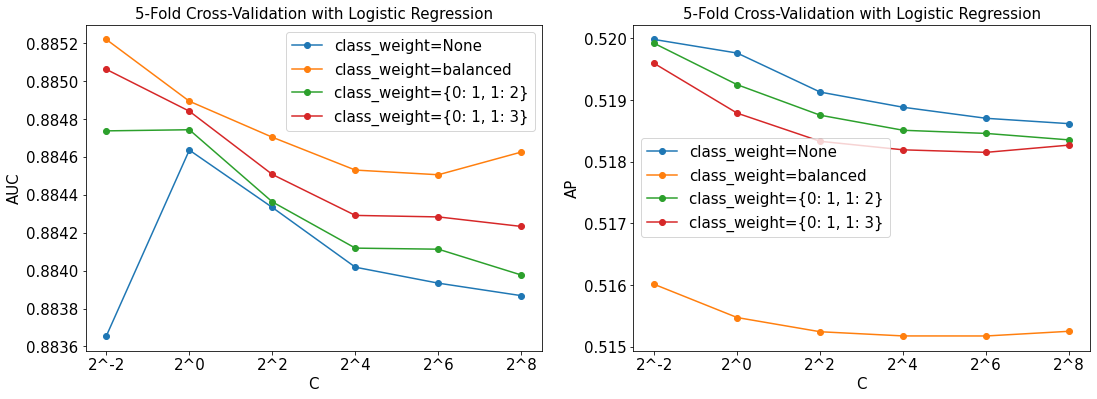

In [21]:
model.plot_auc_ap_lr(X_train_scaled, y_train, cv_fold = 5)

## A-1-1.  Hyperparameter tuning - LR
 In this section, we shall optimize the **AUC** of the classifiers using grid/randomized search, cross-validation, and cost sensitive method

In [22]:
# Class ratio of the negative class to the positive class
neg = y_train == 0
pos = y_train == 1
class_ratio = np.sum(neg)/np.sum(pos)
class_ratio

61.28619986403807

In [24]:
# Range of hyperparameters
params = {'C': [2**x for x in range(-2,5,2)], 
          'class_weight': ['balanced', {0:1, 1:class_ratio}]}
                             
# Grid search
gsearch_log = RandomizedSearchCV(estimator = log_clf, param_distributions = params, 
                                scoring = 'roc_auc', cv = 5, n_jobs = -1, 
                                n_iter = 200, random_state = 42, verbose = 1)

# Fit the training set
gsearch_log.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(gsearch_log.best_estimator_, '../src/model/log_clf.pkl')

# Print results
print('Grid search best AUC scor:', gsearch_log.best_score_)
print('Grid search best parameters:', gsearch_log.best_params_)    

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid search best AUC scor: 0.885671832759102
Grid search best parameters: {'class_weight': 'balanced', 'C': 0.25}


## A-2. Support Vector Machine

In [ ]:
svm_clf = SVC(probability = True, kernel = 'rbf')   
model.eval_metrics_cv(svm_clf, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy', 
                      model_nm = "SVM Classifier")

In [ ]:
model.plot_auc_ap_svm(X_train_scaled, y_train, cv_fold = 5)

## A-2-1. Hyperparameter tuning- SVM

In [ ]:
# Range of hyperparameters
params = {'C': [2**x for x in range(-2,8,2)], 
          'gamma': [2**x for x in range(-11,1,2)],
          'class_weight': ['balanced',{0:1, 1:class_ratio}]
         } 
                                                              
# Randomized search for SVM
svm_clf = SVC(probability = True, kernel = 'rbf')
rsearch_svm = RandomizedSearchCV(svm_clf, param_distributions = params, cv = 5,
                                 scoring = 'roc_auc', n_iter =200,
                                 n_jobs = -1,random_state = 42, verbose = 1) 
# Fit the training set
rsearch_svm.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_svm.best_estimator_, '../src/model/svm_clf.pkl')

print('Best score: ', rsearch_svm.best_score_)
print('Best parameters: ', rsearch_svm.best_params_)  

## A-3. Random Forest

In [ ]:
rf_clf = RandomForestClassifier(random_state = 42)                         
model.eval_metrics_cv(rf_clf, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy', 
                      model_nm = "Random Forest Classifier")

In [ ]:
# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_names, 
                                'Importances': rf_clf.feature_importances_
                                })
# Bar plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(20).plot(kind='barh', figsize = (18,10))
plt.title('Top 20 Feature Importances for Random Forest Classifier')
plt.show()

## A-3-1.  Hyperparameter tuning - RF

In [ ]:
# Range of hyperparameters
params = {'max_features': [0.5, 1, 'sqrt', 'log2', None],
          'max_depth': range(2,8,1),
          'min_samples_split': range(2,10,1),
          'class_weight': ['balanced', {0: 1, 1: class_ratio}]
                         }

# Randomized search
rf_clf = RandomForestClassifier(n_estimators = 1000, random_state = 42)           
rsearch_rf = RandomizedSearchCV(estimator = rf_clf, param_distributions = params, 
                                scoring = 'roc_auc', cv = 5, n_jobs = -1, n_iter = 200, 
                                random_state = 42, verbose = 1)  
# Fit the  training set                                                    
rsearch_rf.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_rf.best_estimator_, '../src/model/rf_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_rf.best_score_) 
print('Randomized search best hyperparameters:', rsearch_rf.best_params_) 

## A-4. XGBoost

In [ ]:
param_dist = {'objective':'binary:logistic', 'eval_metric':'logloss', 'random_state':42}

xgb_clf = xgb.XGBClassifier(**param_dist) 
model.eval_metrics_cv(xgb_clf, X_train_scaled, y_train, cv_fold = 5,scoring = 'accuracy',
                      model_nm = "XGBoost Classifier")

In [ ]:
# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_names,
                               'Importances': xgb_clf.feature_importances_})
# Bar plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(20).plot(kind='barh', figsize = (18,10))
plt.title('Top 20 Feature Importances for XGBoost Classifier')
plt.show()

## A-4-1. Hyperparameter tuning  - XGB

In [ ]:
# Range of hyperparameters
params = {'subsample':[i/10 for i in range(5,9)],
          'colsample_bytree': [i/10 for i in range(5,9)],
          'max_depth': range(2,10,1)
          }

# Randomized search
param_dist = {'objective':'binary:logistic', 'eval_metric':'logloss', 'n_estimators':1000,
              'scale_pos_weight':class_ratio, 'learning_rate':0.1, 'random_state':5,
              'n_jobs':-1
              }
xgb_clf = xgb.XGBClassifier(**param_dist)

rsearch_xgb = RandomizedSearchCV(estimator = xgb_clf, param_distributions = params, 
                                  scoring = 'roc_auc', cv = 5, n_jobs = -1, n_iter = 200, 
                                  random_state = 42, verbose = 1)   
# Fit the  training set                                                            
rsearch_xgb.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_xgb.best_estimator_, '../src/model/xgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_xgb.best_score_) 
print('Randomized search best hyperparameters:', rsearch_xgb.best_params_) 

## 5. LGBM

In [ ]:
param_dict = {'boosting_type':'gbdt', 'num_leaves':31, 'max_depth':- 1, 
              'learning_rate':0.1, 'n_estimators':1000, 'random_state':42
             }
              
lgb_clf = lgb.LGBMClassifier(**param_dict)
model.eval_metrics_cv(lgb_clf, X_train_scaled, y_train, cv_fold = 5, model_nm = 'LGBM Classifier')

In [ ]:
# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_names, 
                               'Importances': lgb_clf.feature_importances_
                              })
# Plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(10).plot(kind='barh', figsize = (18,10))
plt.yticks(rotation = 45)
plt.title('Top 10 Feature Importances for LGBM Classifier')
plt.savefig('../image/lgbm.png')

## A-5-1. Hyperparameter tuning  - LGBM

In [ ]:
# Hyperparameter range
params = {'max_depth': [-1,30,40],
          'num_leaves': range(80,120,10),
          'min_child_samples': range(20,50,10)
          }

# Randomized search
param_dict = {'boosting_type':'gbdt', 'learning_rate':0.1, 
              'n_estimators':1000, 'random_state':42,
              'scale_pos_weight':class_ratio
             }
lgb_clf =  lgb.LGBMClassifier(**param_dict)                       
rsearch_lgbm = RandomizedSearchCV(estimator = lgb_clf, param_distributions = params, 
                                n_iter = 200,scoring = 'roc_auc', cv = 5, 
                                n_jobs = -1, random_state = 42, verbose = 1
                                 )  
# Fit model
rsearch_lgbm.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_lgbm.best_estimator_, '../src/model/lgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_lgbm.best_score_) 
print('Best hyperparameters:', rsearch_lgbm.best_params_) 

In [ ]:
# Load trained model
log_clf = joblib.load('../src/model/log_clf.pkl')
svm_clf = joblib.load('../src/model/svm_clf.pkl')
rf_clf = joblib.load('../src/model/rf_clf.pkl')
xgb_clf = joblib.load('../src/model/xgb_clf.pkl')
lgb_clf = joblib.load('../src/model/lgb_clf.pkl')

In [ ]:
model_dict = {'LR': log_clf, 'SVM': svm_clf, 'RF': rf_clf, 'XGB': xgb_clf, 'LGB': lgb_clf}
roc_scores = []

for i, (name, model_) in enumerate(model_dict.items()):
    score = cross_val_score(model_, X_train_scaled, y_train, cv = 5, scoring = 'roc_auc')
    roc_scores.append(score)

plt.figure(figsize = (12,6))
plt.boxplot(roc_scores)
plt.xticks(np.arange(len(model_dict))+1, list(model_dict.keys()))
plt.title('ROC AUC on 5-Fold Cross-Validation Set', fontsize = 20)
plt.ylabel('ROC AUC (Cross-validation)')
plt.savefig('../image/cv_metric.png')
plt.show()

# C. Resampling Methods
In this section, we will employ two resampling techniques on the training set to balance the classes. However, the final prediction will be made on the imbalanced test set. The idea of resampling is to trick the classifier using a balanced dataset.  

## C-1. Under Sampling  combined with Random Forest Classifier
In undersampling, we reduce the majority class such that it matches the minority class

In [ ]:
# Under sample the majority class
und = RandomUnderSampler(random_state = 42)
X_train_scaled_und, y_train_und = und.fit_resample(X_train_scaled, y_train)

In [ ]:
print('Undersampled training data size:', X_train_scaled_und.shape, y_train_und.shape)

In [ ]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('Undersampled training set class distribution:', np.bincount(y_train_und))

In [ ]:
# Random Forest Classifier cross-validation on the undersampled dataset
rf_und =  RandomForestClassifier(n_estimators = 100, random_state = 42)
model.eval_metrics_cv(svm_und, X_train_scaled_und, y_train_und, cv_fold = 5, 
scoring = 'accuracy', model_nm = "Undersampling with Random Forest Classifier")

## C-2. SMOTE  combined with Random Forest Classifier
In Synthetic Minority Over Sampling Technique (SMOTE), we generate synthetic oberservations to match the minority clas.
SMOTE oversampled the minority class in the training set, so we now have equal class distribution. 

In [ ]:
# Over sample the minority class
sm = SMOTE(random_state = 42)
X_train_scaled_ovsm, y_train_ovsm = sm.fit_resample(X_train_scaled, y_train)

In [ ]:
print('SMOTE training data size:', X_train_scaled_ovsm.shape, y_train_ovsm.shape)

In [ ]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('SMOTE resampled training set class distribution:', np.bincount(y_train_ovsm))

In [ ]:
# Random Forest cross-validation on the SMOTE dataset
rf_ovsm = RandomForestClassifier(random_state = 42)
model.eval_metrics_cv(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, cv_fold = 5, 
scoring = 'accuracy', model_nm = "SMOTE with Random Forest Classifier")

# D. Prediction on the Imbalanced Test Set 
In this section, we make our final prediction on the imbalanced dataset after training the model using the resampling techniques.

## D-1. Normal Imbalanced Dataset

In [ ]:
model.test_pred(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test, 
                    model_nm = "Random Forest Classifier")

## D-2. Undersampled Dataset

In [ ]:
model.test_pred(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test,
                model_nm = "UnderSampling with Random Forest Classifier")

## D-3. SMOTE Dataset

In [ ]:
model.test_pred(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test,
                model_nm = "SMOTE with Random Forest Classifier")

# E.  ROC and PR Curves


In [ ]:
plt.figure(figsize = (20,15))

# Normal imbalanced distribution
model.plot_roc_pr_curves(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 5,
                       color= 'b', label = 'Normal (AUC= %0.2f)')

# Under Sampled distribution
model.plot_roc_pr_curves(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test, cv_fold = 5,
                       color= 'g', label = 'Under Sampled (AUC= %0.2f)')
                     
# SMOTE distribution
model.plot_roc_pr_curves(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test, cv_fold = 5,
                       color= 'r', label = 'SMOTE (AUC= %0.2f)') 

# F. AUC-ROC and AUC-PR for Cross-Validation vs. Test Sets

In [ ]:
plt.figure(figsize = (20,8))

# Normal imbalanced distribution
model.plot_aucroc_aucpr(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 5,
                       marker = 'o', color= 'b', label = 'Normal')

# Under Sampled distribution
model.plot_aucroc_aucpr(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test, cv_fold = 5, 
                        marker = '^', color= 'g', label = 'Under Sampled')
                     
# SMOTE distribution
model.plot_aucroc_aucpr(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test, cv_fold = 5, 
                        marker = 'd', color= 'r', label = 'SMOTE') 